**Introduction**


This study aims to explore the New York City Property Sales dataset to identify relationships between key variables, such as location and size of the property and the sale price.
The dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/new-york-city/nyc-property-sales) and contains the rocords of units sold in New York City over a year - more specifically between 2016 and 2017.

The purpose of the project is to analyze the sales in New York City over time, identify relevant correlations between the different variables and build a significant model to predict the sale price of a property in New York based on the relevant variables.
This analysis is extremely valuable for the City that has a really hot real estate market, and it can be used as a guide for investors and real estate professionals to evaluate the market.


In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm
import scipy.io
import scipy.stats
import random
from functools import partial
from tqdm import trange, tqdm_notebook
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
nyc = pd.read_csv('nyc-rolling-sales.csv')
nyc.head(5)
nyc = nyc.iloc[:, 1:] #remove the first column since it's just a row index
nyc.shape
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null

**Data Cleaning**

To handle data wrangling more efficiently some of variable types need to be changed to numeric, object and date time. Additionally, some feature engineering is required to aid future analysis on the data.
New columns have been added to store the sale year, sale date, age of building and the borough name (note: originally the borough was simply stored as numbers). Additionally, the average sale price per square foot has also been calculated.
Missing, duplicate and inconsist values will also be removed from the dataset.

In [3]:
# Clean data: check data types, create any new features

for _ in ["RESIDENTIAL UNITS","COMMERCIAL UNITS","TOTAL UNITS", "LAND SQUARE FEET" ,"GROSS SQUARE FEET","SALE PRICE" ]:
    nyc[_] = pd.to_numeric(nyc[_], errors = 'coerce')
for _ in ["BOROUGH","NEIGHBORHOOD",'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
               'BUILDING CLASS AT PRESENT','ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT TIME OF SALE']:
    nyc[_] = nyc[_].astype(object)
nyc['SALE DATE'] = pd.to_datetime(nyc['SALE DATE'])
nyc['YEAR'] = nyc['SALE DATE'].dt.year
nyc['MONTH'] = nyc['SALE DATE'].dt.month

nyc['BOROUGH_NUM'] = nyc['BOROUGH']
nyc['BOROUGH'] = nyc['BOROUGH'].map({1:'Manhattan', 2:'Bronx', 3: 'Brooklyn', 4:'Queens',5:'Staten Island'})

# Calculate the age of the building 
nyc['AGE'] = 2017 - nyc['YEAR BUILT']
nyc.info()

# Calculate price per square foot
pd.options.mode.chained_assignment = None
nyc['PRICE PER SQFT'] = nyc['SALE PRICE'] / nyc['GROSS SQUARE FEET'].replace(0, np.nan)

nyc.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  object        
 1   NEIGHBORHOOD                    84548 non-null  object        
 2   BUILDING CLASS CATEGORY         84548 non-null  object        
 3   TAX CLASS AT PRESENT            84548 non-null  object        
 4   BLOCK                           84548 non-null  int64         
 5   LOT                             84548 non-null  int64         
 6   EASE-MENT                       84548 non-null  object        
 7   BUILDING CLASS AT PRESENT       84548 non-null  object        
 8   ADDRESS                         84548 non-null  object        
 9   APARTMENT NUMBER                84548 non-null  object        
 10  ZIP CODE                        84548 non-null  object        
 11  RE

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,MONTH,BOROUGH_NUM,AGE,PRICE PER SQFT
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,1900,2,C2,6625000.0,2017-07-19,2017,7,1,117,1028.726708
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,1900,2,C7,NaN,2016-12-14,2016,12,1,117,NaN
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,1900,2,C7,NaN,2016-12-09,2016,12,1,117,NaN
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,1913,2,C4,3936272.0,2016-09-23,2016,9,1,104,579.374742
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,1900,2,C2,8000000.0,2016-11-17,2016,11,1,117,1733.477790


In [4]:
# Clean data: check for missing values, remove any duplicates and unecessary columns

nyc.replace(' ',np.nan, inplace=True)
nan_counts = nyc.isna().sum()
print("NaN Counts per Column:")
print(nan_counts)

nyc.drop(["ADDRESS", "ZIP CODE", "EASE-MENT", "APARTMENT NUMBER"], axis=1, inplace=True)
nyc = nyc.dropna() 
nyc.drop_duplicates(keep = "last", inplace=True)

NaN Counts per Column:
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                738
BLOCK                                 0
LOT                                   0
EASE-MENT                         84548
BUILDING CLASS AT PRESENT           738
ADDRESS                               0
APARTMENT NUMBER                  65496
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  26252
GROSS SQUARE FEET                 27612
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                        14561
SALE DATE                             0
YEAR                                  0
MONTH                                 0
BOROUGH_NUM                           0
AGE              

In [5]:
#Check dataset after cleaning
nan_counts = nyc.isna().sum()
print("NaN Counts per Column:")
print(nan_counts)

# Handle rows with 0 value
nyc = nyc[nyc['YEAR BUILT'] != 0]
nyc = nyc[nyc['LAND SQUARE FEET'] != 0]
nyc = nyc[nyc['GROSS SQUARE FEET'] != 0]
nyc = nyc[nyc['SALE PRICE'] != 0]

NaN Counts per Column:
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
BUILDING CLASS AT PRESENT         0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
YEAR                              0
MONTH                             0
BOROUGH_NUM                       0
AGE                               0
PRICE PER SQFT                    0
dtype: int64


**Explanatory Data Analysis**


In [6]:
print(nyc.describe())

              BLOCK           LOT  RESIDENTIAL UNITS  COMMERCIAL UNITS  \
count  29192.000000  29192.000000       29192.000000      29192.000000   
mean    5560.302343     61.549055           2.987908          0.311215   
std     3777.932829    124.758061          18.930982         13.815466   
min        5.000000      1.000000           0.000000          0.000000   
25%     2697.500000     19.000000           1.000000          0.000000   
50%     4917.000000     38.000000           2.000000          0.000000   
75%     7847.250000     64.000000           2.000000          0.000000   
max    16319.000000   7501.000000        1844.000000       2261.000000   

        TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  \
count  29192.000000      2.919200e+04       2.919200e+04  29192.00000   
mean       3.297719      4.201780e+03       4.398072e+03   1940.61373   
std       23.579553      3.843936e+04       3.351336e+04     30.44618   
min        0.000000      2.000000e+02    

The distribution of sale price is highly right-skewed, with most of the observations being concentrated between 0 and $1,000,000.00. 
The average sale price in New York is around $1,640,643.
On average the building is around 76 years, with most of the observations being concentrated around 90 years.

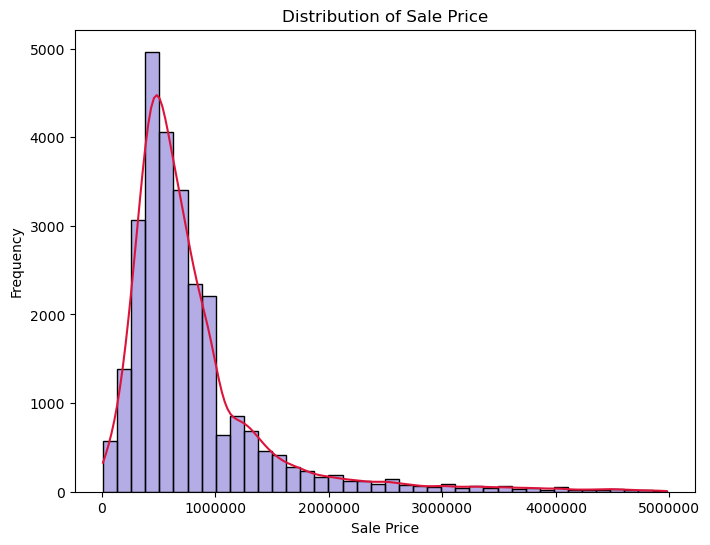

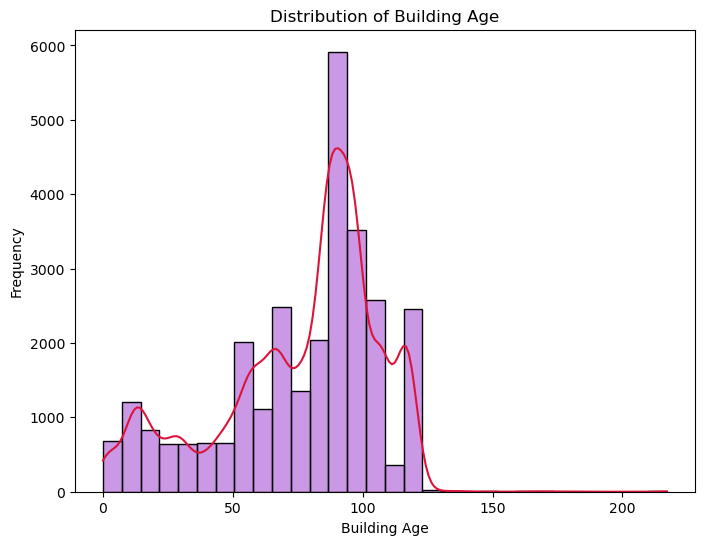

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(nyc[(nyc['SALE PRICE']>10000) & (nyc['SALE PRICE'] < 5000000) ]['SALE PRICE'], kde=True, 
             bins = 40, color = 'slateblue').lines[0].set_color('crimson')
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(nyc['AGE'], bins=30, kde=True, color = 'darkorchid').lines[0].set_color('crimson')
plt.title('Distribution of Building Age')
plt.xlabel('Building Age')
plt.ylabel('Frequency')
plt.show()

From the below box-plot it can be noticed that there are several outliers, observations whose sale price is higher than $2,000,000
There are only few outliers for age, with only a couple of obervations where the building is older than 150 years.

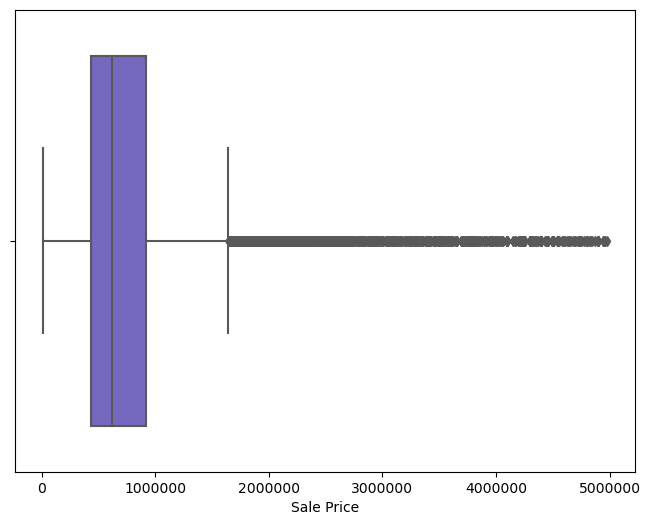

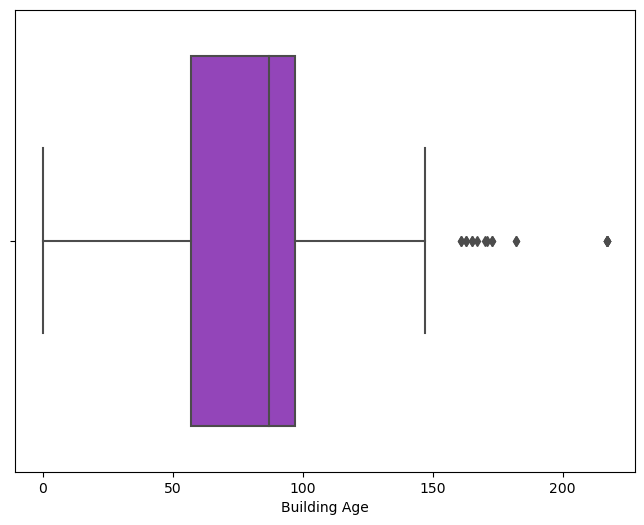

In [8]:
#Boxplot for 'SALE PRICE' to identify any outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=nyc[(nyc['SALE PRICE']>10000) & (nyc['SALE PRICE'] < 5000000)]['SALE PRICE'], color = 'slateblue')
plt.xlabel('Sale Price')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Boxplot for 'YEAR BUILT' (if relevant)
plt.figure(figsize=(8, 6))
sns.boxplot(x=nyc['AGE'], color = 'darkorchid')
plt.xlabel('Building Age')
plt.show()

Manhattan is the most expensive borough in New York, with an average sale price of almost $19,256,870.

The lowest average sale price is in Staten Island (around $528,466) while all the other boroughs are close to or slighly higher than $1,000,000.

However, the most popular boroughs are Queens and Brooklyn with the highest count of sales.

BOROUGH
Bronx            1.022824e+06
Brooklyn         1.512372e+06
Manhattan        1.925687e+07
Queens           9.102807e+05
Staten Island    5.284662e+05
Name: SALE PRICE, dtype: float64


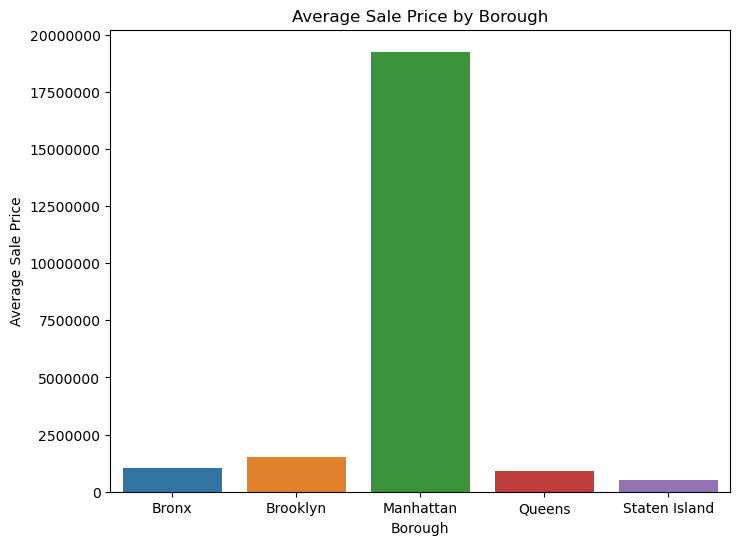

In [9]:
# Group data by borough and calculate the average sale price
borough_avg_sale_price = nyc.groupby('BOROUGH')['SALE PRICE'].mean()

# Display the average sale prices by borough
print(borough_avg_sale_price)

borough_order = sorted(nyc['BOROUGH'].unique())

# Plot the average sale prices by borough
plt.figure(figsize=(8, 6))
sns.barplot(x=borough_avg_sale_price.index, y=borough_avg_sale_price.values, order=borough_order)
plt.title('Average Sale Price by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

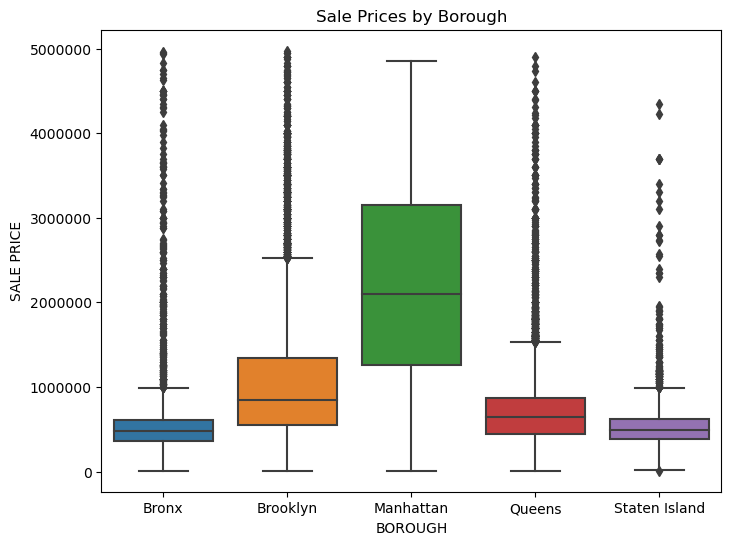

In [10]:
# Compare sale prices across borough
plt.figure(figsize=(8, 6))
sns.boxplot(x='BOROUGH', y=nyc[(nyc['SALE PRICE']>10000) & (nyc['SALE PRICE'] < 5000000)]['SALE PRICE'], data=nyc, 
            order=borough_order)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Sale Prices by Borough')
plt.show()

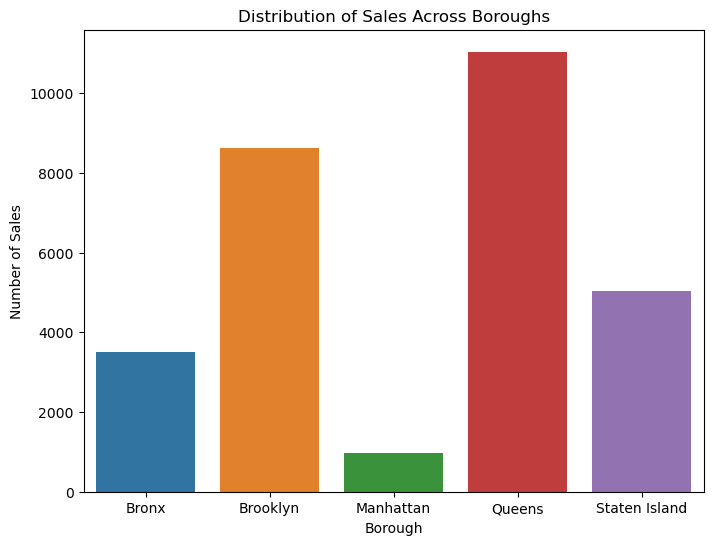

In [11]:
# Plot sales across boroughs
plt.figure(figsize=(8, 6))
sns.countplot(x='BOROUGH', data=nyc, order=borough_order)
plt.title('Distribution of Sales Across Boroughs')
plt.xlabel('Borough')
plt.ylabel('Number of Sales')
plt.show()

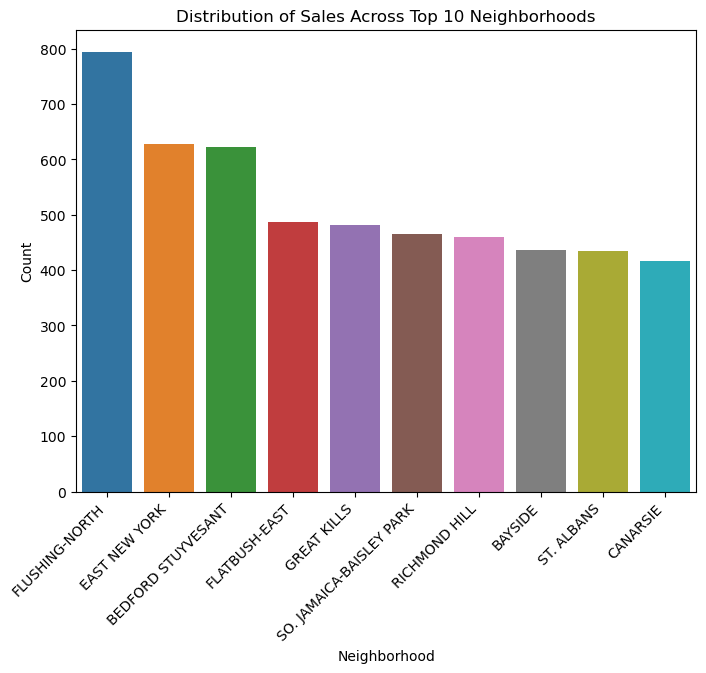

In [12]:
# Plot sales across neighborhoods (top 10 neighborhoods by count)
plt.figure(figsize=(8, 6))
top_10_neighborhoods = nyc['NEIGHBORHOOD'].value_counts().head(10)
sns.barplot(x=top_10_neighborhoods.index, y=top_10_neighborhoods.values)
plt.title('Distribution of Sales Across Top 10 Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

There does not seems to be a linear relationship between the sale price and the building age, since the price varies even for buildings with the same age.

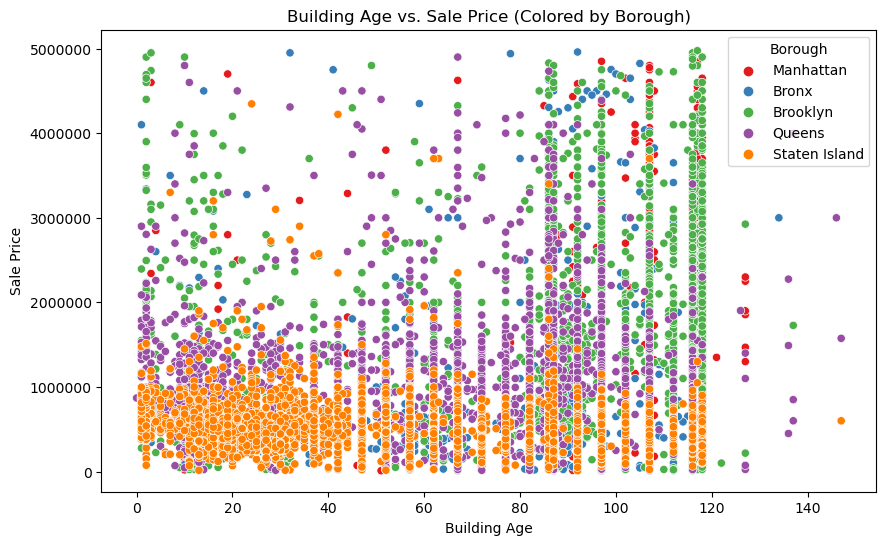

In [13]:
# Scatter plot between Sale Price and Building Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nyc[(nyc['AGE'] < 150)]['AGE'], 
                y=nyc[(nyc['SALE PRICE']>10000) & (nyc['SALE PRICE'] < 5000000)]['SALE PRICE'], 
                data=nyc, hue='BOROUGH', palette='Set1')
plt.title('Building Age vs. Sale Price (Colored by Borough)')
plt.xlabel('Building Age')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Borough', loc='upper right')
plt.show()

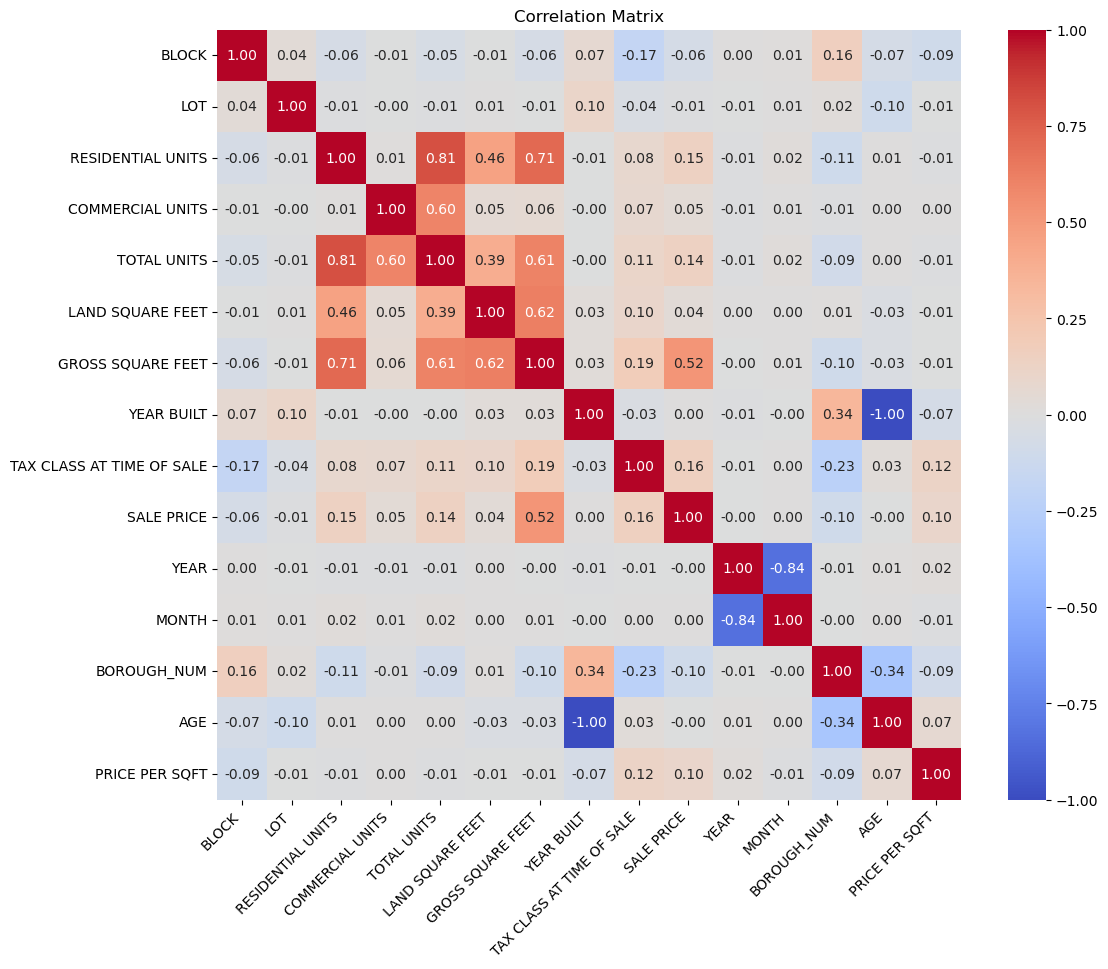

In [14]:
# Correlation Analysis
correlation_matrix = nyc.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()


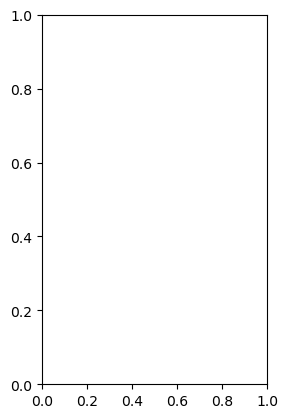

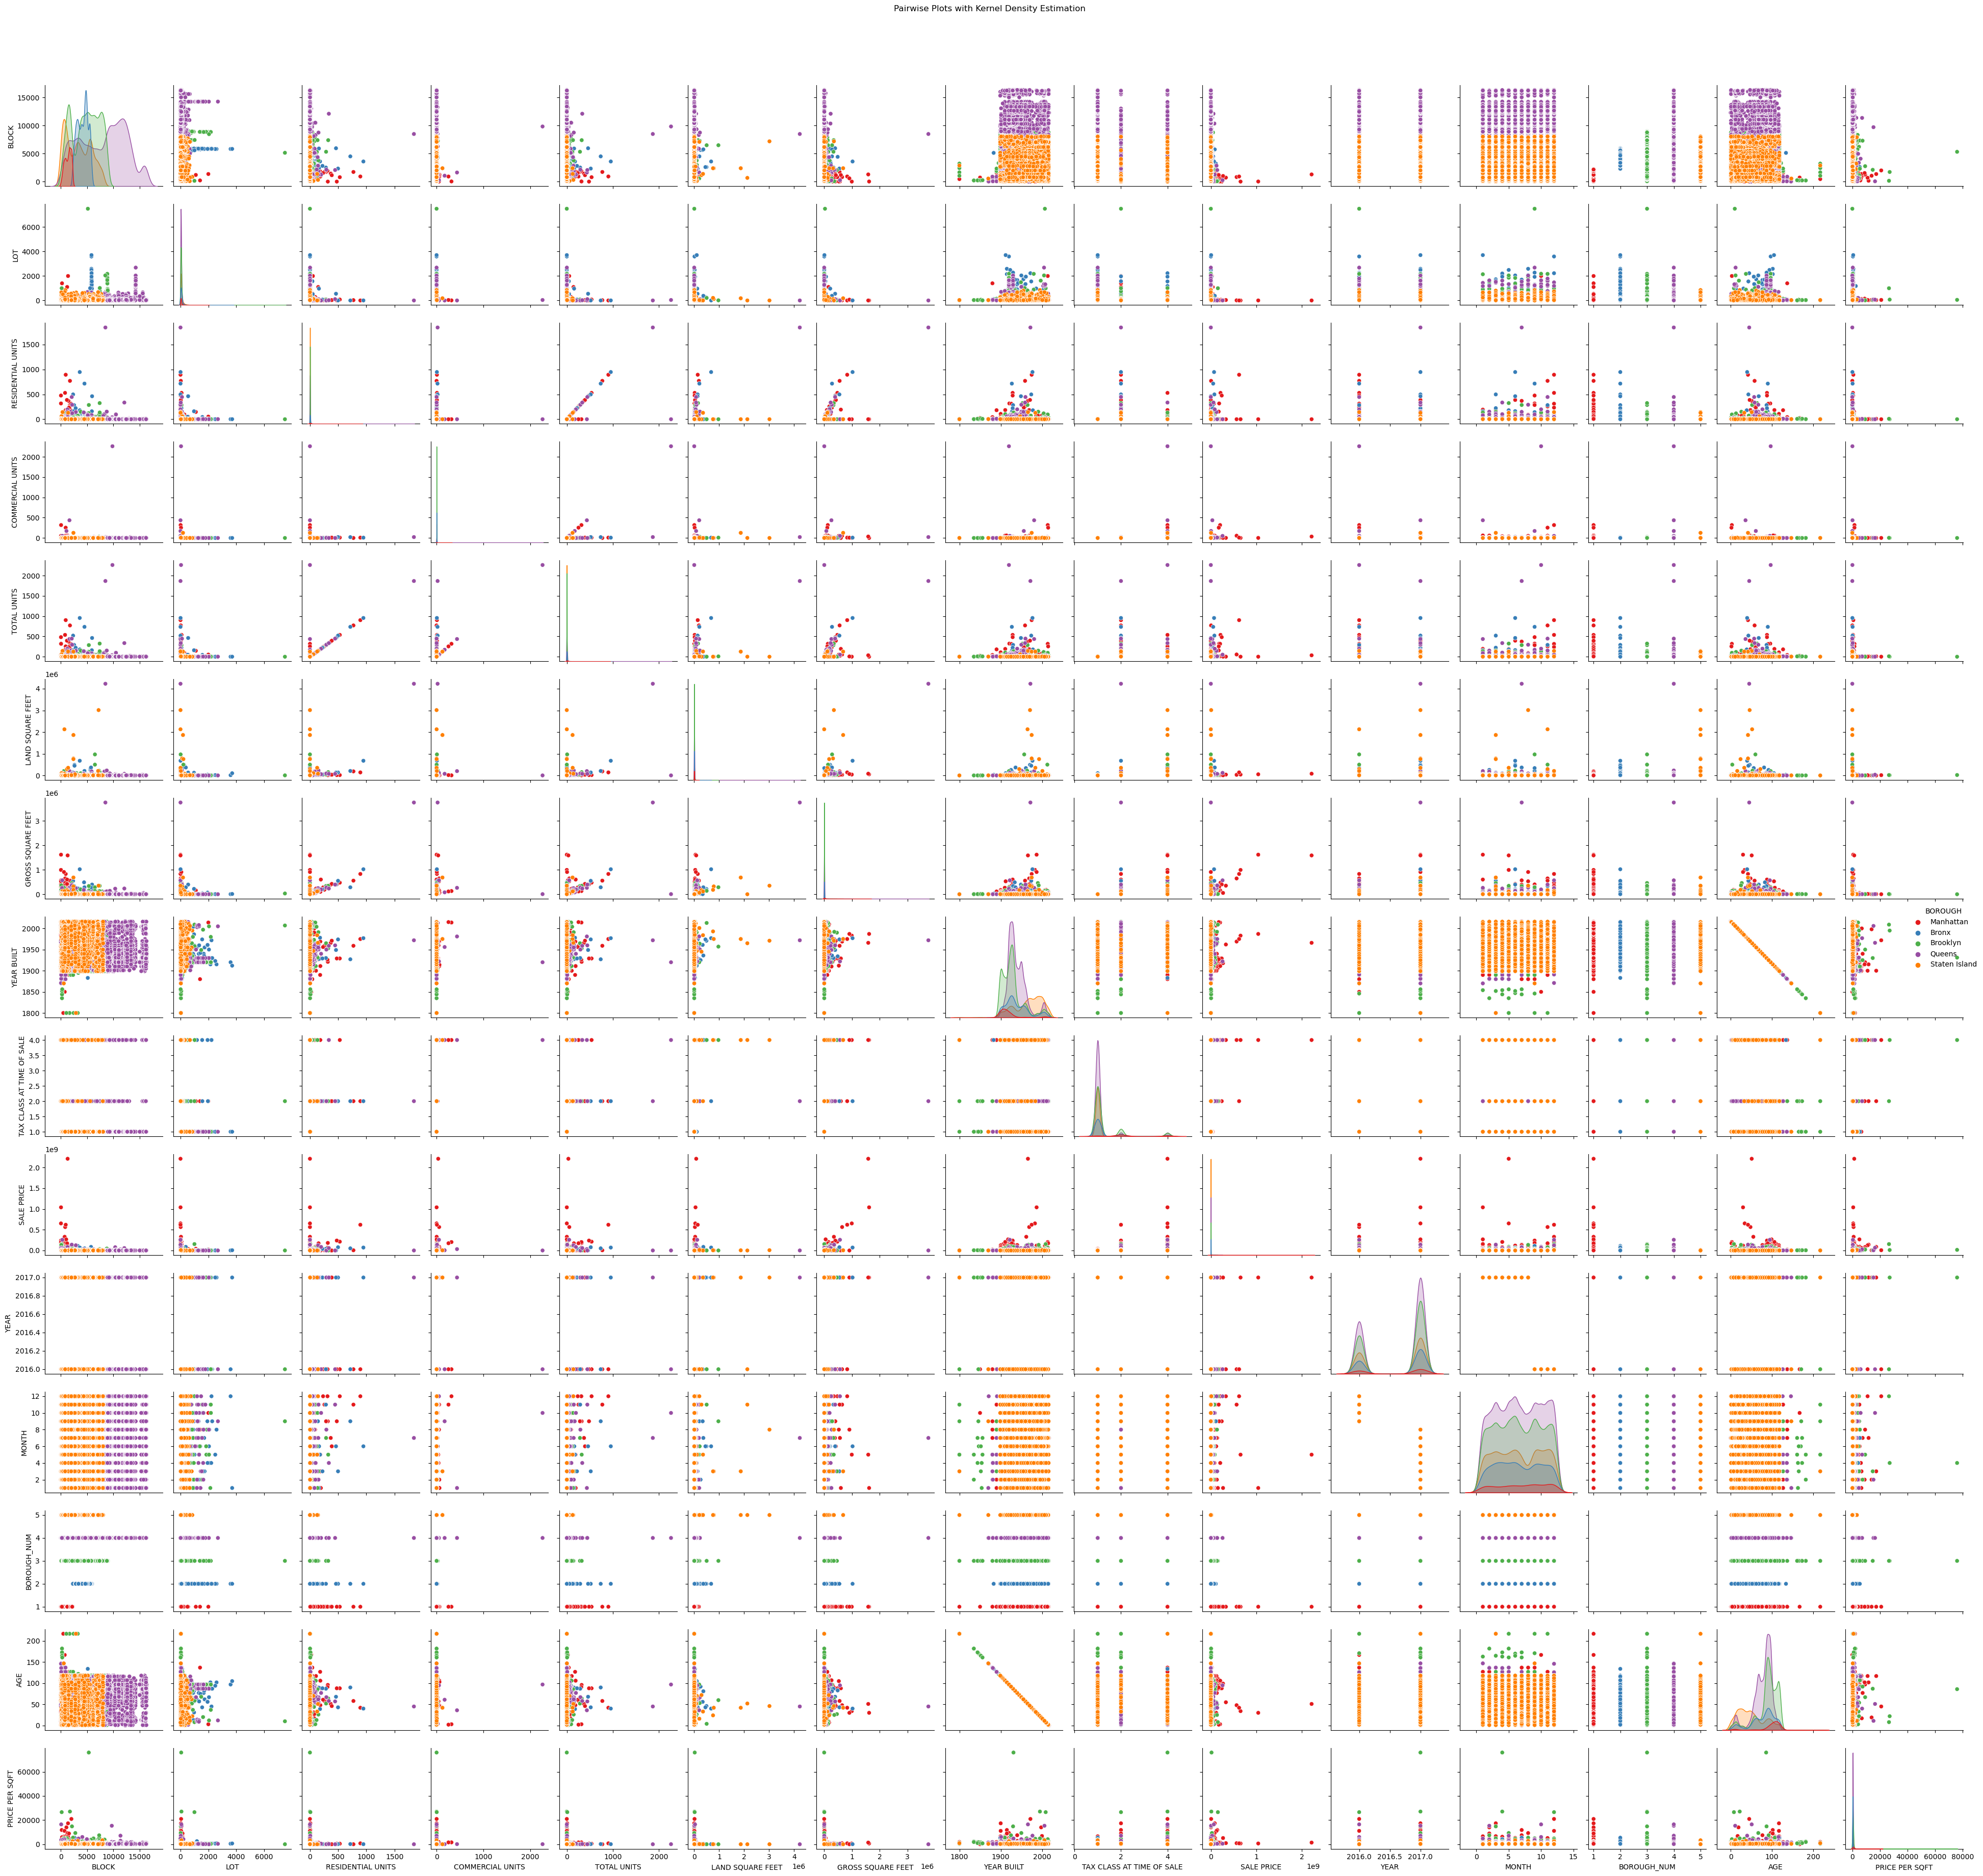

In [15]:
plt.subplot(1, 2, 2)
sns.pairplot(nyc, diag_kind='kde', hue='BOROUGH', palette='Set1')
plt.suptitle('Pairwise Plots with Kernel Density Estimation')
plt.show()

In [16]:
#One-way ANOVA test
# Extract Sale Prices for each borough
alpha = 0.05
borough_sale_prices = [nyc[nyc['BOROUGH'] == b]['SALE PRICE'].dropna() for b in borough_order]
f_statistic, p_value = f_oneway(*borough_sale_prices)
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in Sale Prices between boroughs.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in Sale Prices between boroughs.")

Reject the null hypothesis: There is a significant difference in Sale Prices between boroughs.


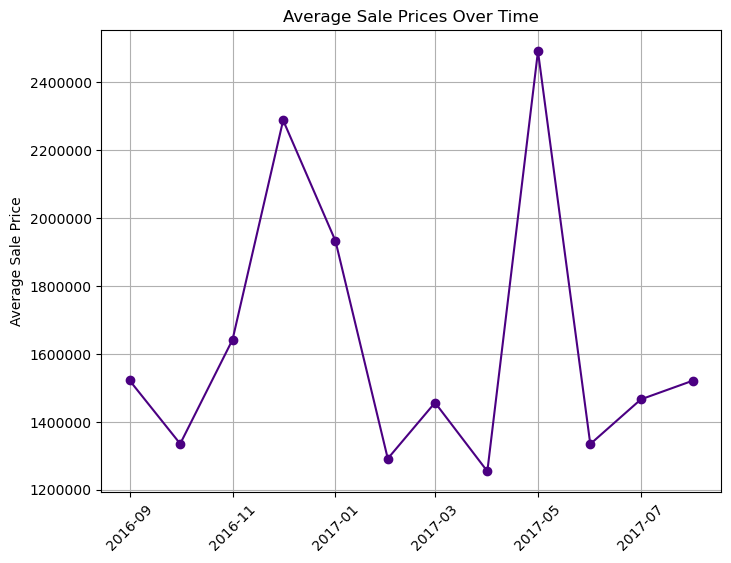

In [17]:
# Group data by year and month and calculate the average Sale Price for each month
monthly_sale_prices = nyc.groupby(['YEAR', 'MONTH'])['SALE PRICE'].mean()
# Reset index to access the year and month as separate columns
monthly_sale_prices = monthly_sale_prices.reset_index()
# Create a date column combining the year and month
monthly_sale_prices['DATE'] = pd.to_datetime(monthly_sale_prices[['YEAR', 'MONTH']].assign(day=1))

# Create a time series plot for Sale Prices over time
plt.figure(figsize=(8, 6))
plt.plot(monthly_sale_prices['DATE'], monthly_sale_prices['SALE PRICE'], marker='o', linestyle='-', color = 'indigo')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average Sale Prices Over Time')
plt.ylabel('Average Sale Price')
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()


In [20]:
#Build predictive models to estimate Sale Prices based on relevant features.
#Split the data into training and testing sets, preprocess the data, and use regression models for prediction.
#Evaluate the model's performance using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).


X = nyc[['BOROUGH_NUM', 'YEAR BUILT']]  
y = nyc['SALE PRICE']

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Create a Linear Regression model (you can choose other models as well)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1900669.810415224
Root Mean Squared Error: 5896794.155670099
